# Global Cross-Time Attention Fusion for Solar Flare Prediction from Multivariate Time Series

In [1]:
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
import pycatch22
import pickle
import numpy as np
import os
import pandas as pd
import aeon
from natsort import natsorted
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# SWAN-SF DATASET

In [2]:
cur_dir = Path.cwd()
parent_folder = cur_dir.parent / 'DATA' / 'Preprocessed-SWANSF-main' 

# Defining the paths
folder_path_train = str(parent_folder) + '/train/'
folder_path_test = str(parent_folder) + '/test/'
print(folder_path_train)

# Extracting train and test partitions
X_train = []
y_train = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_train}Partition{i+1}_train.pkl", 'rb') as f:
        X_train.append(pickle.load(f))
    with open(f"{folder_path_train}Partition{i+1}_Labels_train.pkl", 'rb') as f:
        y_train.append(pickle.load(f))
        
X_test = []
y_test = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_test}Partition{i+1}_test.pkl", 'rb') as f:
        X_test.append(pickle.load(f))
    with open(f"{folder_path_test}Partition{i+1}_Labels_test.pkl", 'rb') as f:
        y_test.append(pickle.load(f))

/Users/onurvural/Desktop/CIKMH01/DATA/Preprocessed-SWANSF-main/train/


In [3]:
SELECTED_PARTITION = 1
# Make list less deep 
X_train = X_train[SELECTED_PARTITION-1] # Training with partition 1
y_train = y_train[SELECTED_PARTITION-1] # Training with partition 1
X_test = X_test[SELECTED_PARTITION] # Testing with partition 2
y_test = y_test[SELECTED_PARTITION] # Testing with partition 2
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

DATASET_NAME = f"SWAN-SF_train_{SELECTED_PARTITION}"

(18773, 60, 24)
(18773,)
(88557, 60, 24)
(88557,)


In [4]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# EVALUATION METRICS

In [5]:
def evaluation_metrics(valLabel, vpredictedLabel):
    TN, FP, FN, TP = metrics.confusion_matrix(valLabel, vpredictedLabel).ravel()
    
    acc = (TP + TN) / (TP + FN + TN + FP)
    pr_pos = TP / (TP + FP) if (TP + FP) > 0 else 0
    pr_neg = TN / (TN + FN) if (TN + FN) > 0 else 0
    rc_pos = TP / (TP + FN) if (TP + FN) > 0 else 0
    rc_neg = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_pos = (2 * pr_pos * rc_pos) / (pr_pos + rc_pos) if (pr_pos + rc_pos) > 0 else 0
    f1_neg = (2 * pr_neg * rc_neg) / (pr_neg + rc_neg) if (pr_neg + rc_neg) > 0 else 0
    P = TP + FN
    N = TN + FP
    HSS1 = (TP + TN - N) / P if P > 0 else 0
    HSS2 = (2 * ((TP * TN) - (FP * FN))) / (P * (FN + TN) + (TP + FP) * N) if (P * (FN + TN) + (TP + FP) * N) > 0 else 0
    CH = ((TP + FP) * (TP + FN)) / (P + N) if (P + N) > 0 else 0
    GS = (TP - CH) / (TP + FP + FN - CH) if (TP + FP + FN - CH) > 0 else 0
    TSS_val = ((TP * TN) - (FP * FN)) / (P * N) if (P * N) > 0 else 0

    print(f"\n Evaluation Metrics:")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives (TN): {TN}")
    print(f"Accuracy: {acc:.6f}")
    print(f"Precision (Positive): {pr_pos:.6f}")
    print(f"Precision (Negative): {pr_neg:.6f}")
    print(f"Recall (Positive): {rc_pos:.6f}")
    print(f"Recall (Negative): {rc_neg:.6f}")
    print(f"F1-Score (Positive): {f1_pos:.6f}")
    print(f"F1-Score (Negative): {f1_neg:.6f}")
    print(f"Heidke Skill Score 1 (HSS1): {HSS1:.6f}")
    print(f"Heidke Skill Score 2 (HSS2): {HSS2:.6f}")
    print(f"Gilbert Skill Score (GS): {GS:.6f}")
    print(f"True Skill Statistic (TSS): {TSS_val:.6f}")


# MODEL 

In [7]:
class TransformerEncoderModule(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderModule, self).__init__()
        self.attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.attn_dropout = nn.Dropout(dropout)

        self.ffn_norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-head Self Attention with residual
        x_norm = self.attn_norm(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.attn_dropout(attn_out)

        # Feed-forward Network with residual
        x_norm = self.ffn_norm(x)
        ffn_out = self.ffn(x_norm)
        x = x + ffn_out

        return x


In [9]:
class TransformerClassifierWithCTAF(nn.Module):
    def __init__(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, num_classes, 
                 num_global_tokens=4, dropout=0.1):
        super(TransformerClassifierWithCTAF, self).__init__()
        self.embed_dim = input_shape[1]  # input shape: [batch, seq_len, num_features]
        self.num_global_tokens = num_global_tokens

        # Learnable global tokens: [1, N, embed_dim]
        self.global_tokens = nn.Parameter(torch.randn(1, num_global_tokens, self.embed_dim))

        # Cross-attention layer: global tokens attend to input sequence
        self.cross_attn = nn.MultiheadAttention(embed_dim=self.embed_dim, num_heads=num_heads, batch_first=True)

        # Transformer blocks (local self-attention)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderModule(self.embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_transformer_blocks)
        ])

        # Global average pooling (after fusion)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # MLP Classifier head
        self.mlp = nn.Sequential()
        last_dim = self.embed_dim * 2  # concat pooled local + pooled global tokens
        for i, unit in enumerate(mlp_units):
            self.mlp.add_module(f"linear_{i}", nn.Linear(last_dim, unit))
            self.mlp.add_module(f"relu_{i}", nn.ReLU())
            self.mlp.add_module(f"dropout_{i}", nn.Dropout(dropout))
            last_dim = unit

        self.output_layer = nn.Linear(last_dim, num_classes)

    def forward(self, x):  # x shape: [batch, seq_len, embed_dim]
        B = x.size(0)

        # Cross-attention: global tokens attend to input sequence
        global_tokens_expanded = self.global_tokens.expand(B, -1, -1)  # [B, N, embed_dim]
        global_attn_out, _ = self.cross_attn(global_tokens_expanded, x, x)  # [B, N, embed_dim]

        # Fuse global tokens back with local features by concatenation
        x = torch.cat([x, global_attn_out], dim=1)  # seq_len + N tokens total

        # Process with Transformer blocks (local self-attention on extended sequence)
        for block in self.transformer_blocks:
            x = block(x)

        # Separate local tokens and global tokens after transformer blocks
        local_tokens = x[:, :-self.num_global_tokens, :]  # [B, seq_len, embed_dim]
        fused_global_tokens = x[:, -self.num_global_tokens:, :]  # [B, N, embed_dim]

        # Pool local tokens over seq_len and global tokens over token dim
        local_pooled = self.global_avg_pool(local_tokens.permute(0, 2, 1)).squeeze(-1)  # [B, embed_dim]
        global_pooled = fused_global_tokens.mean(dim=1)  # [B, embed_dim]

        # 6) Concatenate pooled vectors
        pooled = torch.cat([local_pooled, global_pooled], dim=1)  # [B, 2*embed_dim]

        # 7) MLP classifier head
        x = self.mlp(pooled)
        out = self.output_layer(x)
        return out



# TRAIN & TEST PROCEDURE

Epoch 1, Train Acc: 0.8988, Train Loss: 0.2770
Epoch 2, Train Acc: 0.9541, Train Loss: 0.1365
Epoch 3, Train Acc: 0.9646, Train Loss: 0.1044
Epoch 4, Train Acc: 0.9680, Train Loss: 0.0935
Epoch 5, Train Acc: 0.9681, Train Loss: 0.0890


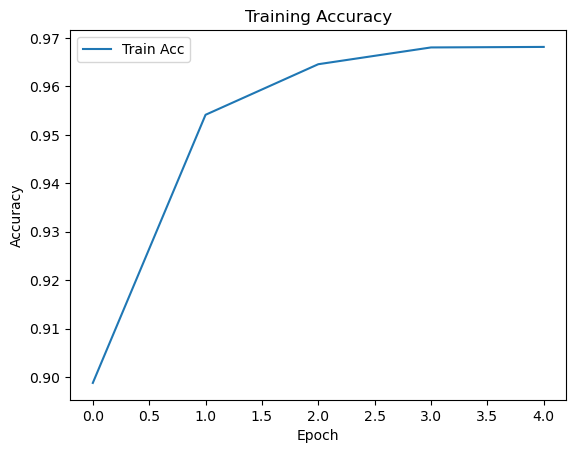

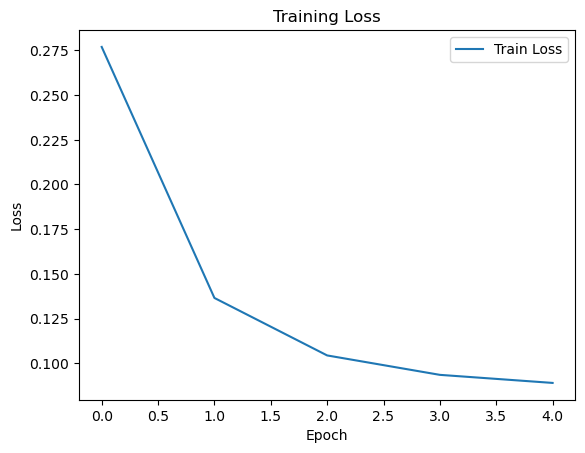

In [13]:
num_classes = len(np.unique(y_train))

model = TransformerClassifierWithCTAF(
    input_shape=X_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=10,
    mlp_units=[128, 64],
    num_classes=num_classes,
    num_global_tokens=4,
    dropout=0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_accs, train_losses = [], []

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / total)
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss / total:.4f}")

plt.plot(train_accs, label='Train Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        y_preds.extend(pred)
        y_trues.extend(yb.numpy())


y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

cm = confusion_matrix(y_trues, y_preds)
print("\nConfusion Matrix:")
print(cm)

if len(np.unique(y_trues)) == 2:
    print("\nEvaluation Metrics:")
    evaluation_metrics(y_trues, y_preds)


Confusion Matrix:
[[66949 20207]
 [   39  1362]]

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 1362
False Positives (FP): 20207
False Negatives (FN): 39
True Negatives (TN): 66949
Accuracy: 0.771379
Precision (Positive): 0.063146
Precision (Negative): 0.999418
Recall (Positive): 0.972163
Recall (Negative): 0.768151
F1-Score (Positive): 0.118589
F1-Score (Negative): 0.868655
Heidke Skill Score 1 (HSS1): -13.451106
Heidke Skill Score 2 (HSS2): 0.091600
Gilbert Skill Score (GS): 0.047998
True Skill Statistic (TSS): 0.740314


# ----------------------------------------------------------

# BASELINES

In [9]:
# ROCKET
from sktime.classification.kernel_based import RocketClassifier
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Detect the number of unique classes
num_classes = len(np.unique(y_train))
# Create and train classifier
classifier = RocketClassifier(num_kernels=1000)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)  
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

if len(np.unique(y_test)) == 2:
    print("\nEvaluation Metrics:")
    _ = evaluation_metrics(y_test, y_pred)

(19807, 60, 24) (19807,) (42510, 60, 24) (42510,)

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 1424
False Positives (FP): 21957
False Negatives (FN): 0
True Negatives (TN): 19129
Accuracy: 0.483486
Precision (Positive): 0.060904
Precision (Negative): 1.000000
Recall (Positive): 1.000000
Recall (Negative): 0.465584
F1-Score (Positive): 0.114816
F1-Score (Negative): 0.635357
Heidke Skill Score 1 (HSS1): -14.419242
Heidke Skill Score 2 (HSS2): 0.055148
Gilbert Skill Score (GS): 0.028356
True Skill Statistic (TSS): 0.465584


In [15]:
# LTV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Detect the number of unique classes
num_classes = len(np.unique(y_train))


# Extract the last row for each instance
X_train_LTV = X_train[:, -1, :]
X_test_LTV = X_test[:, -1, :]
print(X_train_LTV.shape) 
print(X_test_LTV.shape)

logreg_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
logreg_model.fit(X_train_LTV, y_train)

y_pred = logreg_model.predict(X_test_LTV)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

if len(np.unique(y_test)) == 2:
    print("\nEvaluation Metrics:")
    _ = evaluation_metrics(y_test, y_pred)

(18773, 24)
(88557, 24)

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 1355
False Positives (FP): 22313
False Negatives (FN): 46
True Negatives (TN): 64843
Accuracy: 0.747519
Precision (Positive): 0.057250
Precision (Negative): 0.999291
Recall (Positive): 0.967166
Recall (Negative): 0.743988
F1-Score (Positive): 0.108102
F1-Score (Negative): 0.852945
Heidke Skill Score 1 (HSS1): -14.959315
Heidke Skill Score 2 (HSS2): 0.080638
Gilbert Skill Score (GS): 0.042013
True Skill Statistic (TSS): 0.711154


In [28]:
# LSTM
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np

# Detect the number of unique classes
num_classes = len(np.unique(y_train))

# Convert labels to categorical if multiclass
if num_classes > 2:
    print("multi classification")
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    print("binary classification")
    y_train_encoded = y_train  # For binary classification
    y_test_encoded = y_test

# Define the LSTM model
lstm_model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(num_classes, activation='softmax') if num_classes > 2 else Dense(1, activation='sigmoid')
])


optimizer = SGD(learning_rate=0.0001)
lstm_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)


print(X_train.shape)
print(X_test.shape)

# early stopping
lstm_model.fit(
    X_train, 
    y_train_encoded, 
    epochs=5
)

# Evaluate the model
y_pred_proba = lstm_model.predict(X_test)

if num_classes > 2:
    y_pred = y_pred_proba.argmax(axis=-1)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', average='macro')
else:
    y_pred = (y_pred_proba > 0.5).astype("int32").flatten()
    roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Metrics

if len(np.unique(y_test)) == 2:
    print("\nEvaluation Metrics:")
    _ = evaluation_metrics(y_test, y_pred)

binary classification
(18773, 60, 24)
(88557, 60, 24)
Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


587/587 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5582 - loss: 0.6802
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6726 - loss: 0.6757
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7537 - loss: 0.6713
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8042 - loss: 0.6662
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8375 - loss: 0.6618
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 1401
False Positives (FP): 61288
False Negatives (FN): 0
True Negatives (TN): 25868
Accuracy: 0.307926
Precision (Positive): 0.022348
Precision (Negative): 1.000000
Recall (Positive): 1.000000
Recall (Negative): 0.296801
F1-Score (Positive): 0.043720
F1-Score (Negative): 0.457743
Heidke Skill Score 1 (HSS1): -42.745896
Heidke Skill Score 2 (HSS2): 0.013179
Gilbert Skill Score (GS): 0.006633
True Skill Statistic (TSS): 0.296801


In [26]:
# SVM
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import numpy as np

# Detect number of classes
num_classes = len(np.unique(y_train))

# Extract the last time step from each sequence
X_train_SVM = X_train[:, -1, :]
X_test_SVM = X_test[:, -1, :]

print(X_train_SVM.shape)
print(X_test_SVM.shape)

# Initialize SVM model
svm_model = SVC(kernel='rbf', probability=True)  # you can change kernel to 'linear', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train_SVM, y_train)

# Predict
y_pred = svm_model.predict(X_test_SVM)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Evaluate if binary classification
if len(np.unique(y_test)) == 2:
    print("\nEvaluation Metrics:")
    _ = evaluation_metrics(y_test, y_pred)

(19320, 24)
(75365, 24)
Confusion Matrix:
 [[65117  9258]
 [  511   479]]

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 479
False Positives (FP): 9258
False Negatives (FN): 511
True Negatives (TN): 65117
Accuracy: 0.870377
Precision (Positive): 0.049194
Precision (Negative): 0.992214
Recall (Positive): 0.483838
Recall (Negative): 0.875523
F1-Score (Positive): 0.089307
F1-Score (Negative): 0.930223
Heidke Skill Score 1 (HSS1): -8.867677
Heidke Skill Score 2 (HSS2): 0.067059
Gilbert Skill Score (GS): 0.034693
True Skill Statistic (TSS): 0.359361


In [17]:
# Generic Transformer
# Transformer Encoder Block
def transformer_encoder_block(embed_dim, num_heads, ff_dim):
    return nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True),
        nn.LayerNorm(embed_dim),
        nn.Sequential(
            nn.Conv1d(embed_dim, ff_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(ff_dim, embed_dim, kernel_size=1)
        )
    )

# Transformer-based Model
class TransformerClassifier(nn.Module):
    def __init__(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embed_dim = input_shape[1]
        self.transformer_blocks = nn.ModuleList([
            transformer_encoder_block(self.embed_dim, num_heads, ff_dim) for _ in range(num_transformer_blocks)
        ])

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.mlp = nn.Sequential()
        last_dim = self.embed_dim
        for i, unit in enumerate(mlp_units):
            self.mlp.add_module(f'dense_{i}', nn.Linear(last_dim, unit))
            self.mlp.add_module(f'relu_{i}', nn.ReLU())
            last_dim = unit
        self.output = nn.Linear(last_dim, num_classes)

    def forward(self, x):
        for block in self.transformer_blocks:
            norm = block[0](x)
            attn_out, _ = block[1](norm, norm, norm)
            x = attn_out + x

            norm2 = block[2](x)
            conv_input = norm2.permute(0, 2, 1)
            conv_out = block[3](conv_input).permute(0, 2, 1)
            x = conv_out + x

        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.mlp(x)
        return self.output(x)


Epoch 1, Train Acc: 0.9238, Train Loss: 0.2359
Epoch 2, Train Acc: 0.9635, Train Loss: 0.1110
Epoch 3, Train Acc: 0.9699, Train Loss: 0.0902
Epoch 4, Train Acc: 0.9746, Train Loss: 0.0781
Epoch 5, Train Acc: 0.9758, Train Loss: 0.0697


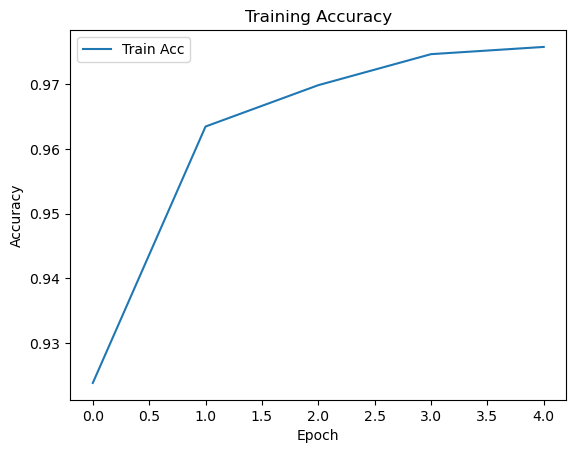

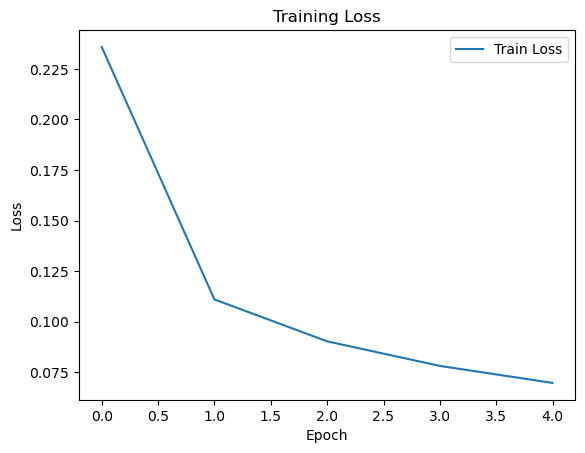

In [26]:
# Model init
num_classes = len(np.unique(y_train))
model = TransformerClassifier(
    input_shape=X_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=10,
    mlp_units=[128, 64],
    num_classes=num_classes
)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_accs, train_losses = [], []

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / total)
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss / total:.4f}")

# Plot training accuracy and loss
plt.plot(train_accs, label='Train Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        y_preds.extend(pred)
        y_trues.extend(yb.numpy())

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

cm = confusion_matrix(y_trues, y_preds)
print("\nConfusion Matrix:")
print(cm)

if len(np.unique(y_trues)) == 2:
    print("\nEvaluation Metrics:")
    _ = evaluation_metrics(y_trues, y_preds)


Confusion Matrix:
[[84852  2304]
 [  602   799]]

Evaluation Metrics:

 Evaluation Metrics:
True Positives (TP): 799
False Positives (FP): 2304
False Negatives (FN): 602
True Negatives (TN): 84852
Accuracy: 0.967185
Precision (Positive): 0.257493
Precision (Negative): 0.992955
Recall (Positive): 0.570307
Recall (Negative): 0.973565
F1-Score (Positive): 0.354796
F1-Score (Negative): 0.983164
Heidke Skill Score 1 (HSS1): -1.074233
Heidke Skill Score 2 (HSS2): 0.340418
Gilbert Skill Score (GS): 0.205123
True Skill Statistic (TSS): 0.543872


In [44]:
# EXCON: https://github.com/OnurVural/excon